# Water Segmentation Model

## Imports

In [1]:
import os
import numpy as np
import tifffile as tiff
import cv2
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Define image and mask directories
train_img_dir = "/kaggle/input/dataset-1/data/images"
train_mask_dir = "/kaggle/input/dataset-1/data/labels"


2025-07-18 08:01:49.903884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752825710.146204      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752825710.214137      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data generator

In [2]:
class TifSegmentationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=8, target_size=(128, 128), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle

        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.indexes = np.arange(len(self.image_files))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_img = []
        batch_mask = []

        for i in batch_indexes:
            img_path = os.path.join(self.image_dir, self.image_files[i])
            mask_path = os.path.join(self.mask_dir, self.mask_files[i])

            img = tiff.imread(img_path).astype(np.float32)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0

            mask = np.array(Image.open(mask_path).convert('L'))
            mask = cv2.resize(mask, self.target_size)
            mask = (mask > 0).astype(np.float32)

            batch_img.append(img)
            batch_mask.append(mask[..., np.newaxis])  # keep channel dimension

        return np.array(batch_img), np.array(batch_mask)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


## preview a Batch

In [3]:
train_gen = TifSegmentationDataGenerator(train_img_dir, train_mask_dir, batch_size=4)

# Preview a batch
x, y = next(iter(train_gen))
print("Image shape:", x.shape)  # (4, 128, 128, 12)
print("Mask shape:", y.shape)  # (4, 128, 128, 1)


Image shape: (4, 128, 128, 12)
Mask shape: (4, 128, 128, 1)


## Visualize a sample

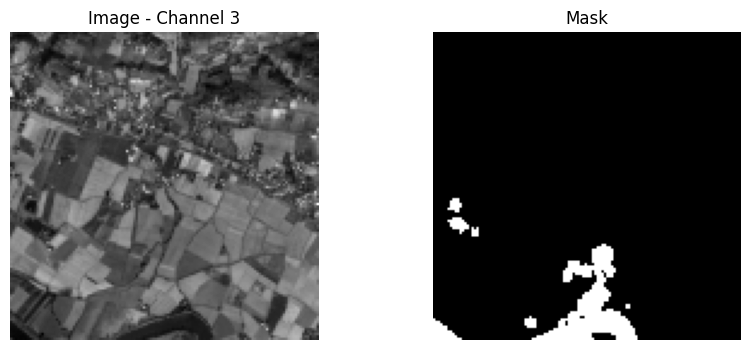

In [4]:
def visualize_sample(images, masks, index=0, channel=0):
    image = images[index]
    mask = masks[index]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image[..., channel], cmap='gray')
    plt.title(f"Image - Channel {channel}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask[..., 0], cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.show()

visualize_sample(x, y, index=0, channel=3)


In [5]:
from sklearn.model_selection import train_test_split

# Get sorted file lists
image_files = sorted(os.listdir(train_img_dir))
mask_files = sorted(os.listdir(train_mask_dir))

# Full paths
image_paths = [os.path.join(train_img_dir, f) for f in image_files]
mask_paths = [os.path.join(train_mask_dir, f) for f in mask_files]

# Split into train and temp (val + test)
train_imgs, temp_imgs, train_masks, temp_masks = train_test_split(
    image_paths, mask_paths, test_size=0.3, random_state=42
)

# Split temp into val and test
val_imgs, test_imgs, val_masks, test_masks = train_test_split(
    temp_imgs, temp_masks, test_size=0.5, random_state=42
)


In [6]:
def custom_generator(image_paths, mask_paths, batch_size=8, target_size=(128, 128)):
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_img = []
            batch_mask = []

            for j in range(i, min(i + batch_size, len(image_paths))):
                img = tiff.imread(image_paths[j]).astype(np.float32)
                img = cv2.resize(img, target_size)
                img = img / 255.0

                mask = np.array(Image.open(mask_paths[j]).convert('L'))
                mask = cv2.resize(mask, target_size)
                mask = (mask > 0).astype(np.float32)

                batch_img.append(img)
                batch_mask.append(mask[..., np.newaxis])

            yield np.array(batch_img), np.array(batch_mask)


## creating the model

In [7]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    return model


### Training the model

In [8]:
model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Generators
train_gen = custom_generator(train_imgs, train_masks, batch_size=8)
val_gen = custom_generator(val_imgs, val_masks, batch_size=8)

steps_per_epoch = len(train_imgs) // 8
val_steps = len(val_imgs) // 8

history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=15
)


2025-07-18 08:02:08.993178: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 701ms/step - accuracy: 0.8503 - loss: 0.4073 - val_accuracy: 0.8975 - val_loss: 0.2848
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 617ms/step - accuracy: 0.8981 - loss: 0.3091 - val_accuracy: 0.8973 - val_loss: 0.2789
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.9112 - loss: 0.2706 - val_accuracy: 0.8606 - val_loss: 0.3240
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.9158 - loss: 0.2514 - val_accuracy: 0.8989 - val_loss: 0.2609
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 634ms/step - accuracy: 0.9131 - loss: 0.2456 - val_accuracy: 0.8991 - val_loss: 0.2624
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 608ms/step - accuracy: 0.9123 - loss: 0.2372 - val_accuracy: 0.8568 - val_loss: 0.3437
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 625ms/step - accuracy: 0.9068 - loss: 0.2450 - val_accuracy: 0.9001 - val_loss: 0.2613
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 797ms/step - accuracy: 0.9086 - loss: 0.2425 - val_accu

### evaluating

In [9]:
# Get total number of test steps
test_gen = custom_generator(test_imgs, test_masks, batch_size=4)
test_steps = len(test_imgs) // 4

# Evaluate on test data
loss, accuracy = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9137 - loss: 0.2598
Test Loss: 0.2242
Test Accuracy: 92.17%


### Predicting and comparing

In [10]:
def predict_and_visualize(model, test_images, test_masks, index=0, channel=0):
    image = test_images[index][np.newaxis, ...]  # Add batch dimension
    true_mask = test_masks[index]

    # Predict
    pred_mask = model.predict(image)[0]  # Remove batch dimension

    # Binarize prediction
    pred_mask_bin = (pred_mask > 0.5).astype(np.float32)

    # Plot
    plt.figure(figsize=(15, 4))

    # Input image (showing selected channel)
    plt.subplot(1, 3, 1)
    plt.imshow(image[0, ..., channel], cmap='gray')
    plt.title(f"Input Image (Channel {channel})")
    plt.axis('off')

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[..., 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_bin[..., 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


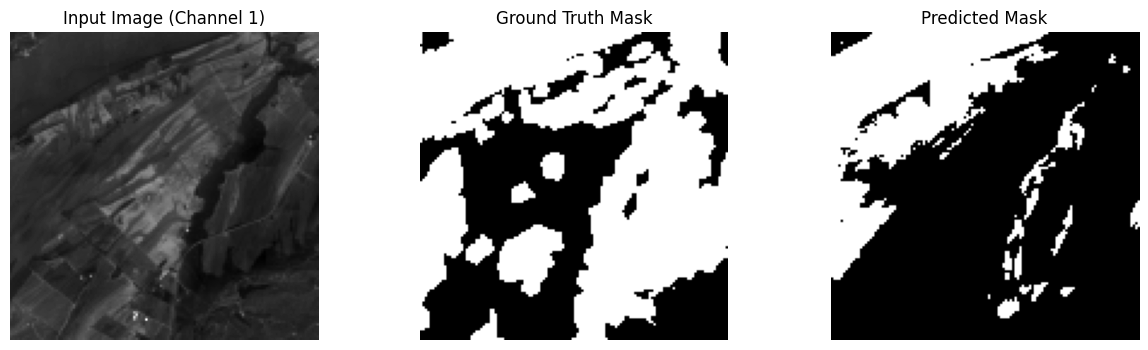

In [11]:
# Get one batch of test data
test_imgs, test_masks = next(test_gen)

predict_and_visualize(model, test_imgs, test_masks, index=2, channel=1)
